<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Image similarity is often used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest users comparable products.

In this tutorial we build an image retrieval system based on leveraging DNNs trained for image classification. Given a query image, we can then find the most similar images in the reference set by computing the pairwise distances as illustrated below, and by returning the reference images with the lowest distance to the query image. 

The distance between two images is computed by:
<img src="media/image_similarity_diagram2.jpg" width="700px" />

- Representing each image using the output of a DNN which was pre-trained on millions of images, and fine-tuned on images from the same domain. The input to the DNN is an image, and the output is the penultimate layer which, for the ResNet-18 model used in this tutorial, consists of 512-floating point values. Note that we use only a single DNN which takes each of the two images in turn as input.
- Normalizing each of the 512-floats DNN image representations (aka. embeddings or features) to have a L2 norm of one.
- Finally, computing the distance between the two input images given as the L2 distance between their respective DNN representations.

Representing images as the output of a DNN is a powerful approach and shown to give good results on a wide variety of tasks.

This notebook starts by loading a dataset and splitting it into a training and a validation set. The training set is used to refine an ImageNet pre-trained ResNet-18 DNN, which is then used to compute the DNN features for each image. The validation set is used in an image retrieval example where, given a query image, the top similar images are displayed, followed by a quantitative evaluation of the proposed system.


<i><b>Note:</b> We will use the terms `embedding` and `feature` interchangeably throughout this tutorial, to refer to the DNN representation for each image.</i>

## Initialization <a id="libraries"/>

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
from copy import deepcopy
import numpy as np
import random
import sys

# fast.ai
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *

# Other advanced libraries
from operator import itemgetter
from pathlib import Path
from sklearn.neighbors import BallTree
from torch.cuda import get_device_name

# Computer Vision repository
sys.path.extend([".", "../.."]) # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.similarity.data import comparative_set_builder, SaveFeatures
from utils_cv.similarity.metrics import compute_topk_similar, positive_image_rank_list, positive_in_top_k
from utils_cv.similarity.plot import plot_comparative_set, plot_rank_and_set_size, plot_similars
from utils_cv.similarity.widget import DistanceWidget

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
#which_processor()

Fast.ai version = 1.0.48


## Data preparation <a id="data-prep"/>

We start with the preparation of our data, and the setting of a few parameters. We use our *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle.

In [4]:
# Set dataset, model and evaluation parameters
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# DNN configuration and learning parameters 
EPOCHS_HEAD = 1 #4
EPOCHS_BODY = 1 #12
LEARNING_RATE = 1e-4
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet18
IM_SIZE       = 300

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

Training set: 108 images
Validation set: 26 images


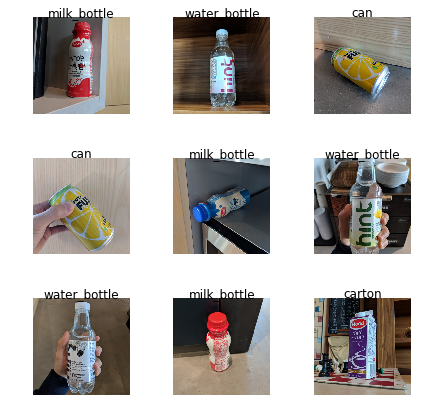

In [27]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data = (ImageList.from_folder(DATA_PATH) 
        .split_by_rand_pct(valid_pct=0.2, seed=20) 
        .label_from_folder() 
        .transform(size=IM_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

print(f'Training set: {len(data.train_ds.x)} images\nValidation set: {len(data.valid_ds.x)} images')

# Display example images
data.show_batch(rows=3, figsize=(6,6))

## Classification model fine-tuning <a id="classif"/>

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) model from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model using our training set. We use the same training parameters here and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

In [6]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    # ps=0.5  # dropout rate
)

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.710447,1.806717,0.312500,0.115385,00:37


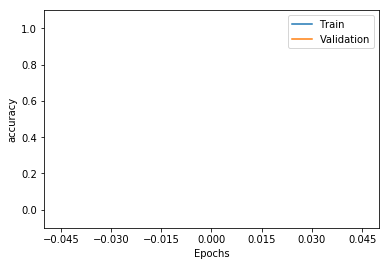

In [7]:
# Train the last layer
learn.fit_one_cycle(EPOCHS_HEAD, LEARNING_RATE)

Let's now unfreeze all the layers and fine tune the model with our data

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,1.562823,1.430826,0.333333,0.423077,00:34


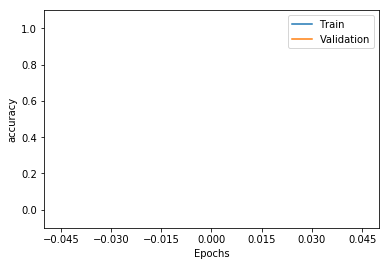

In [8]:
learn.unfreeze()
learn.fit_one_cycle(EPOCHS_BODY, LEARNING_RATE)

## Feature extraction <a id="feat"/>

Before computing the feature representation for each image, let's look at its architecture.

In [9]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Let's, more particularly, focus on the last part. Fast.ai's version of this model is composed of a different set of layers (here: `(1): Sequential`). As discussed at the start of this notebook, we use the output of the penultimate layer (here: `(6): BatchNorm1d`) as our image representation.

The following line will allow us to extract the penultimate layer (ie 512 floating points vector) after running an image  through the model.

In [10]:
# Use last batch normalization layer as image representation
embedding_layer = learn.model[1][6]  ## [1][6] correspond to the indices discussed above
print(embedding_layer)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [11]:
featurizer = SaveFeatures(embedding_layer) 

# Compute DNN embeddings for the training set
learn.get_preds(data.train_ds)
train_im_paths = [str(x) for x in list(data.train_ds.items)]
train_features = dict(zip(train_im_paths, featurizer.features))
print(f"Computed DNN features for the {len(train_features)} training images, each consisting of {len(train_features[train_im_paths[0]])} floating point values.")

# Compute DNN embeddings for the validation set
learn.get_preds(data.valid_ds)
valid_im_paths = [str(x) for x in list(data.valid_ds.items)]
valid_features = dict(zip(valid_im_paths, featurizer.features))
print(f"Computed DNN features for the {len(valid_features)} validation images, each consisting of {len(valid_features[valid_im_paths[0]])} floating point values.")


Computed DNN features for the 26 validation images, each consisting of 512 floating point values.


## Image Retrieval Example
The code sample below shows how to find and display the the most similar images in the validation set, given a query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](00_webcam.ipynb) notebook.

In [12]:
# Get the DNN feature for the query image
query_im_path = valid_im_paths[0]
query_feature = valid_features[query_im_path]

Query image path: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\milk_bottle\72.jpg
Top most similar image with L2 distance of 0.00: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\milk_bottle\72.jpg
Second most similar image with L2 distance of 1.08: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\carton\57.jpg


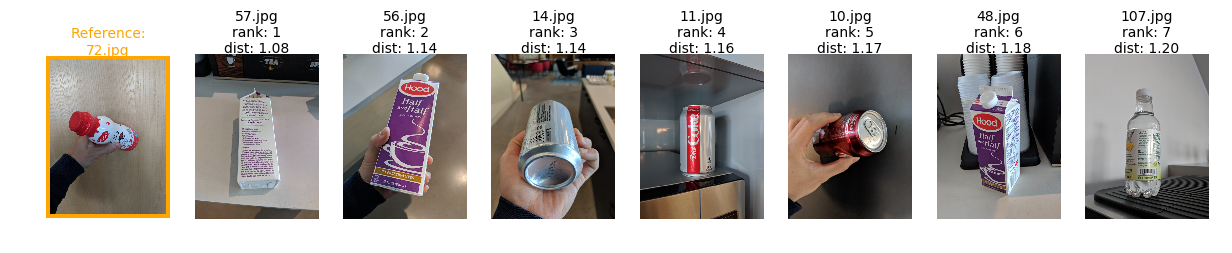

In [74]:
# Compute distance between the query image and all reference images
similars = compute_topk_similar(query_feature, valid_features)
print(f"Query image path: {query_im_path}")
print(f"Top most similar image with L2 distance of {similars[0][1]:.2f}: {similars[0][0]}")
print(f"Second most similar image with L2 distance of {similars[1][1]:.2f}: {similars[1][0]}")
plot_similars(similars, num_rows=1, num_cols=8, figsize=(15,5))

## Quantitative evaluation

To measure accuracy, we create so called "comparative sets" using a test set of images which were not seen before. Each comparative set consists of a `query` image and 100 `distractor` images where exactly 1 of the 100 images has the same label as the query image. The goal of the ...

Here, we consider several comparative sets to be able to measure the overall goodness of our model and results. As we will see later in this notebook, we will focus on 2 metrics: `positive in top k` and `median rank`. They essentially track how good our model is at generating image embeddings, such that the positive example (i.e. image of the same class as the reference) is the closest of the comparative images to the reference one.

Aside from the training set, we will refer to comparative sets. These are groups of images that were not seen during training nor during fine-tuning. Each of these comparative sets contains a reference image, i.e. the image for which we want to find similar photos, and a set of random images to compare it to.

### Comparative sets creation <a id="compar-sets"/>

Our model is ready to be used to compute image embeddings. The only thing we now need is sets of comparative images. We build them here from the data set aside for validation.

Each comparative set is composed of:

- <b>A reference image:</b> image to which the rest of the images of the set will be compared to find similar images to it
- <b>A positive example:</b> image of the same class as the reference image -- If our model is well trained, we expect the positive example to be the image the most similar to the reference image
- <b>Negative examples:</b> set of images from all the other classes -- We expect these to be "further away" from the reference image than the positive example

Due to the randomness of the split between training and validation data, the number of images in each of the "other" classes may differ.

In the cells below, we generate these sets of images using our `comparative_set_builder` helper function.

In [ ]:
# Build multiple sets of comparative images from the images of the validation set
comparative_sets = comparative_set_builder(data.valid_ds)
print(f"*comparative_sets* contains {len(comparative_sets)} sets of reference and comparative images")

The `comparative_sets` object is a dictionary defined as follows:
- <b>Key:</b> Reference image path
- <b>Value:</b> List of paths of comparative images -- This list is composed of 1 positive and multiple negative examples.

This object contains as many keys as there are images in our validation set. In other words, we created a comparative set for each validation image.

Let's examine one of these sets.

In [ ]:
# Retrieve the path of the reference image of the first comparative set
# and the list of paths of images to compare to that reference
first_ref_im_path, first_comparative_set = next(iter(comparative_sets.items()))

# Add the path of the reference image to the list of paths
first_comparative_set_paths = [first_ref_im_path] + first_comparative_set
print(f"We will compare *{'/'.join(Path(first_ref_im_path).parts[-2:])}* to: \
      \n\n{['/'.join(Path(im_path).parts[-2:]) for im_path in first_comparative_set]}")

# Plot the reference image, the positive example and 4 of the negative examples
plot_comparative_set(first_comparative_set_paths, 5)

<i><b>Note:</b> The order in which the comparative images are listed here has no impact on the results obtained below.</i>

### 4.C Similarity computation <a id="similarity"/>


Since we want to compare image embeddings to determine image similarity, we first need to extract these embeddings. We will do so by running our images through a trained classifier model, such as the one we trained in the [01_training_introduction.ipynb](../../classification/notebooks/01_training_introduction.ipynb) notebook.



For each of our comparative sets, we can now use our model to extract the corresponding image embeddings, compute the distances to the reference image, and rank the other images by distance to it.

For this, we need to first:
- Save, through the `SaveFeatures()` hook, the features we obtained from the batch normalization layer we referenced above
- Run the comparative set of images through the model we trained, and get the corresponding predictions using `predict()`
- Extract the values of the features we just saved, i.e. the image embeddings we need to find similar images.

In [ ]:
similarities_list = []
counter = 0
print("Processing:")

# For each comparative set
for ref_im_path in comparative_sets:
    if counter % 5 == 0:
        print(f"Reference # {counter}/{len(comparative_sets)}")
    
    # Extract the image paths
    im_list = [str(im_path) for im_path in comparative_sets[ref_im_path]]
    comparative_set_paths = [ref_im_path] + im_list
    
    # Save the features of the last batch normalization layer
    featurizer = SaveFeatures(embedding_layer)
    
    # Compute the predictions
    for im_path in comparative_set_paths:
        learn.predict(open_image(str(im_path)))

    # Extract the embeddings
    features = featurizer.features
    
    # Associate image path to image embedding
    # The resulting dictionary is then used in the following distance computation function (compute_topk_similar)
    feature_dict = dict(zip(comparative_set_paths, features))

    # Compute distances and rank comparative images
    ref_im_features = feature_dict[ref_im_path]
    dist_tuple = compute_topk_similar(ref_im_features, feature_dict) #, distance=DISTANCE, top_k=len(comparative_set_paths))
    # Here, "top_k" = total number of images in the current comparative set, 
    # so we can get the rank of the positive image, even when it is > TOP_K
    
    # Append to similarities_list, which contains 
    # the list of ranked comparative images, 
    # for each comparative set
    similarities_list.append(dist_tuple)
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Store results of first comparative set for 
    # approximative nearest neighbor search (cf. Appendix)
    if counter == 0:
        first_features = deepcopy(features)
    
    counter += 1

In the cell above, for each comparative set, we extracted an embedding for the reference image and for each of the other images  (i.e. positive and negative examples). We stored them in the `features` object. We then computed distances between the reference image and the other images, and ranked the latter by increasing distance from the former. We saved the results in the `dist_tuple` object, which is a tuple of the format (reference image, [ranked comparative images]).

Here, we considered the $L_2$ distance, so we computed $ \sqrt{\sum_{j=1}^{512}{(emb_{ref}[j] - emb_{im}[j])^{2}}} $, where $emb_{ref}$ is the embedding of the reference image and $emb_{im}$ that of any of the comparative images.

Our `compute_topk_similar()` function can also compute other types of distances, such as $L_1$ and cosine similarity. By default, we chose to normalize our image embeddings before computing the distance between them. This can be changed in the `compute_vector_distance()` sub-function that is available in the same library as `compute_topk_similar()`.

Now that we have ranked the images for each of our comparative sets, let's examine some results. Below, we plot those for our first comparative set.

In [ ]:
# Display the ranked images
num_cols = 7
num_rows = int(len(similarities_list[0])/num_cols)
plot_similars(similarities_list[0], num_rows=num_rows+1, num_cols=num_cols)

# To display the TOP-k, we can take a subset of similarities_list[0]:
# plot_similars(similarities_list[0][0:TOP_K+2], num_rows=3, num_cols=4)

Ideally, results should be such that the positive example is the most similar to our reference image. In cases where the results are not as good, training on a bigger dataset, or changing the [dropout rate `ps`](https://docs.fast.ai/vision.learner.html#cnn_learner) or the learning rate may improve the outcome.

## 5. Performance metrics <a id="performance"/>

To assess our model performance and the "goodness" of our results properly, we need to define specific metrics.

Here, we focus on:
- Positive in top k: Throughout all comparative sets, for how many of them were we able to get the positive example in the top k similar images?
- Median rank: Median rank of the positive example across all comparative sets.

Ideally, our metrics would be equal to 100% and 1, respectively, which means that the positive image would always be found in the top k images, and would actually be the closest to the reference.

So, let's compute these metrics and plot the distribution of ranks we obtained.

In [ ]:
# Compute the rank of the positive example for each comparative set
# and return the list of these ranks across sets
rank_list = positive_image_rank_list(similarities_list)
median_rank = np.median(rank_list)
print(f"The positive example ranks {median_rank}, as a median, across our {len(rank_list)} comparative sets")

In [ ]:
# Determine the length of each comparative set
set_sizes = [len(comparative_sets[x]) for x in comparative_sets]

# Display the distribution of positive example ranks
# and of sizes of comparative sets (as it varies across sets)
plot_rank_and_set_size(rank_list, set_sizes, show_set_size=True)

# Use show_set_size=False to only display the distribution of ranks

In [ ]:
print(f"The positive image is:\n --> {positive_in_top_k(rank_list, 10)}% of the time in the top 10 images\
      \n --> {positive_in_top_k(rank_list, 5)}% of the time in the top 5 images \
      \n --> {positive_in_top_k(rank_list, 1)}% of the time the most similar to the reference.")

## 6. Next steps <a id="next"/>

The best results for image similarity are typically obtained when the model trained is a siamese network or when it leverages triplet loss. This is what we will plan on sharing soon. In the meantime, we can try and train this model with a bigger dataset.

## Appendix <a id="appendix"/>

### A. Alternative visualization tool

With our `DistanceWidget`, we can display the results in a different fashion. Here, we can interact with a user interface and navigate between the images of a comparative set, in distance order. In the example below, we consider the first comparative set we processed.

In [ ]:
# Extract the first comparative set distances
# This contains a list of tuples: (image path, distance from reference)
first_comparative_set_distances = similarities_list[0]

# Extract the Path() object for each of the comparative images in this set
im_paths = [Path(tup[0]) for tup in first_comparative_set_distances]

# Extract the labels from the paths of the images
labels = [Path(tup[0]).parts[-2] for tup in first_comparative_set_distances]

# Extract the path of the root of our FridgeObjects dataset
path = Path(first_comparative_set_distances[0][0]).parent.parent

# Create an ImageDataBunch object, which is expected by our DistanceWidget below
data2 = ImageDataBunch.from_lists(path, im_paths, labels=labels, bs=len(labels), valid_pct=0.)

In [ ]:
# Construct the *DistanceWidget* object by passing:
# - the data from the *data2* object
# - the respective distances that are stored in the *first_comparative_set_distances* object
w_results = DistanceWidget(
    dataset=data2.train_ds,
    distances=np.asarray([tup[1] for tup in first_comparative_set_distances])
)

# Display the widget
display(w_results.show())

### B. Alternative way of retrieving the most similar images

In the dataset we used here, the maximum number N of images we had in our comparative sets was small (N< 30). We could then afford to compute the distance between our reference and all the other images in each of our sets. In a real life scenario, however, the size of the comparative set may be very big, with thousands of images or more. Using brute force to search for the top k nearest neighbors then becomes inefficient. In that case, it is preferable to use an approximate method that is optimized for large (N) and high dimensional (D) datasets. A [Ball Tree](https://scikit-learn.org/stable/modules/neighbors.html#ball-tree) is a solution often considered, as its query time grows as [O\[Dlog(N)\]](https://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm), compared to O\[DN\] for brute force.

In the cell below, we demonstrate how to extract the TOP_K images using a Ball Tree, on the first of our comparative sets.

<i><b>Notes:</b></i>
- In our case, the number of image embeddings is &lt; 30, so the best method to use is the brute force, as we did initially.
- Other solutions, such as [locality sensitive hashing](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23) (LSH) are also popular to find nearest neighbors in large, high dimensional datasets. This [library](https://pypi.org/project/LocalitySensitiveHashing/) is an example implementation in python.

In [ ]:
# Build the tree with all our image embeddings
normalized_features = first_features / np.linalg.norm(first_features, axis=1).reshape(first_features.shape[0],1)
btree = BallTree(normalized_features, leaf_size=5, metric='euclidean')
# We normalized the embeddings, and chose "euclidean" distance to match our "L2" distance from above

# Query the tree for the reference image only
ref_im_embedding = np.reshape(normalized_features[0,:], (-1, 512))
top_k_closest_im = btree.query(ref_im_embedding, k=TOP_K+1, return_distance=True)

# Notes:
# 1. We convert the reference image embedding into a 2D array so it has the same last dimension as the *features* object
# 2. We reduce *leaf_size* from 30 to 5 to force BallTree to execute as BallTree and not in the Brute Force mode
# 3. *btree.query()* returns a tuple of arrays: (array of distances, array of image indices), 
#    where each array is of shape (comparative set size, TOP_K+1)

# Sort the image paths in the order returned by the query to the Ball Tree
sorted_im_paths = itemgetter(*top_k_closest_im[1][0])(first_comparative_set_paths)
# The [0] index refers to the reference image
# Extract the associated distances
distances = top_k_closest_im[0][0]
# Build the list of (image path, distance to reference image) needed for our *plot_similars* function
similar_from_tree = [(im_path, dist) for im_path, dist in zip(sorted_im_paths, distances)]
# Display the results
plot_similars(similar_from_tree, num_rows=3, num_cols=4)

Depending on the comparative set, the results may be slightly different from those obtained using an exact nearest neighbors method.

In [ ]:
UNUSED TEXT:

As shown on the diagram below, this image retrivel notebook implements the follow steps:
1. Fine tune an image classification DNN using an annotated training dataset.
1. Use this DNN to compute a feature representation for each image, given by the activation of the penultimate layer of the DNN. In this example, the representation (also referred to as image embedding) consists of 512 floating point values which are normalized to have an L2 norm of 1.
1. Given a query image, compute the distance to all images in a reference set. This is based on a metric which takes the DNN embeddings of two images as input, and outputs the L2 distance between them.
1. Sort and return the images with lowest distance.


For each comparative set:
2. Run each image of the set, separately, through this model, and extract the values obtained in the penultimate layer of the model
   - This layer is the last one before the probabilities of each class are computed
   - These values constitute a vector that is often called `image embedding`
   - For the model we are considering here, this vector is composed of 512 float values
3. Compute the $L_2$ distance between the reference image, and each of the other images of the comparative set, using their respective image embeddings
4. Sort the images as a function of distance to the reference image
5. Rank these images, rank 1 being assigned to the closest image to the reference one.